In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pastis/PASTIS/metadata.geojson
/kaggle/input/pastis/PASTIS/NORM_S2_patch.json
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40526.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40374.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_30078.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_20493.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_20160.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10060.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_30542.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_30691.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_20518.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_20059.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_30315.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_30645.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_30173.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40459.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40385.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10440.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_30304.npy
/kaggle/input/pastis/PASTIS/DATA_S2/S2_20590.npy
/kaggle/input/pastis/PASTI

In [3]:
import logging

# Remove all handlers associated with the root logger object.
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
# Reconfigure logging again, this time with a file.
logging.basicConfig(level=logging.INFO, format='%(filename)s:%(lineno)s %(levelname)s:%(message)s')

# create logger
logger = logging.getLogger()

In [8]:
import random
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import matplotlib
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision
import keras.backend as K

# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

DATASET_DIR = '/kaggle/input/pastis/PASTIS/'

In [6]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [10]:
class Singleton(type):
    _instances = {}

    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)
        return cls._instances[cls]

class Metadata(metaclass=Singleton):
    def __init__(self):
        self.dataset_dir = DATASET_DIR
        self._metadata = self._load_metadata_dataframe()
        self._norm_metadata = self._load_norm_metadata()

    @property
    def metadata(self):
        return self._metadata

    @property
    def norm_metadata(self):
        return self._norm_metadata

    def _load_norm_metadata(self):
        return pd.read_json(os.path.join(self.dataset_dir, "NORM_S2_patch.json")).to_dict()

    def _load_metadata_dataframe(self):
        """
        Processing patch metadata and extracting the following features:
        Patch_path, Fold, Patch_id, N_parcel, Parcel_cover, Tile, i_date (date of time series object {i})
        :return: pandas dataframe with metadata of Sentinel-2 patches.
        """
        with open(os.path.join(self.dataset_dir, 'metadata.geojson')) as f:
            metadata = json.load(f)
            metadata = pd.json_normalize(metadata, record_path='features', max_level=1)

        # Processing dates
        dates = pd.DataFrame(metadata['properties.dates-S2'].values.tolist())
        for column in dates.columns:
            d = dates[column]
            dates[f'{column}_date'] = pd.to_datetime(d, format='%Y%m%d')
            dates.drop(columns=[column], inplace=True)

        metadata['Semantic_segmentation_path'] = metadata['properties.ID_PATCH'].apply(lambda x: f'{DATASET_DIR}ANNOTATIONS/TARGET_{x}.npy')
        metadata['Patch_path'] = metadata['properties.ID_PATCH'].apply(lambda x: f'{DATASET_DIR}DATA_S2/S2_{x}.npy')
        metadata.drop(
            columns=['id', 'type', 'properties.id', 'geometry.type', 'geometry.coordinates', 'properties.dates-S2'],
            inplace=True)
        metadata.rename(
            columns={'properties.Fold': 'Fold', 'properties.N_Parcel': 'N_parcel', 'properties.ID_PATCH': 'Patch_id',
                     'properties.Parcel_Cover': 'Parcel_cover', 'properties.TILE': 'Tile'}, inplace=True)

        patches_metadata = pd.concat([metadata, dates], ignore_index=False, axis=1)
        patches_metadata.set_index('Patch_path', inplace=True)

        return patches_metadata

patches_metadata = Metadata().metadata
patches_metadata

Fold  Patch_id  N_parcel  \
Patch_path                                                                   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy     1     10000       119   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10001.npy     2     10001       111   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10002.npy     4     10002       131   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10003.npy     5     10003        75   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10004.npy     4     10004        46   
...                                                ...       ...       ...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40558.npy     2     40558        33   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40559.npy     5     40559        24   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40560.npy     3     40560         7   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40561.npy     3     40561         5   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40562.npy     4     40562         3   

                                                  Parcel_cover    Tile  \
Patch_path                                                               
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy      0.808032  t30uxv   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10001.npy      0.501986  t30uxv   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10002.npy      0.638722  t30uxv   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10003.npy      0.866824  t30uxv   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10004.npy      0.204906  t30uxv   
...                                                        ...     ...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40558.npy      0.783991  t32ulu   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40559.npy      0.129896  t32ulu   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40560.npy      0.255358  t32ulu   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40561.npy      0.054305  t32ulu   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40562.npy      0.030340  t32ulu   

                                                                         Semantic_segmentation_path  \
Patch_path                                                                                            
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10001.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10002.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10003.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10004.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
...                                                                                             ...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40558.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40559.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40560.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40561.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40562.npy  /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...   

                                                     0_date     1_date  \
Patch_path                                                               
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy 2018-09-24 2018-09-29   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10001.npy 2018-09-24 2018-09-29   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10002.npy 2018-09-24 2018-09-29   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10003.npy 2018-09-24 2018-09-29   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10004.npy 2018-09-24 2018-09-29   
...                                                     ...        ...   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40558.npy 2018-09-17 2018-09-22   
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40559.npy 2018-09-17 2018-0

In [11]:
patches_metadata.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2433 entries, /kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy to /kaggle/input/pastis/PASTIS/DATA_S2/S2_40562.npy
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Fold                        2433 non-null   int64         
 1   Patch_id                    2433 non-null   int64         
 2   N_parcel                    2433 non-null   int64         
 3   Parcel_cover                2433 non-null   float64       
 4   Tile                        2433 non-null   object        
 5   Semantic_segmentation_path  2433 non-null   object        
 6   0_date                      2433 non-null   datetime64[ns]
 7   1_date                      2433 non-null   datetime64[ns]
 8   2_date                      2433 non-null   datetime64[ns]
 9   3_date                      2433 non-null   datetime64[ns]
 10  4_date                      2433 n

In [12]:
NUMBER_OF_SPECTRA = 10

def normalize_patch_spectra(patch):
    """Utility function to normalize the Sentinel-2 patch spectra.
       The patch must consist of 10 spectra and the shape n*n*10."""
    norms = Metadata().norm_metadata['Fold_1']
    return (patch - norms['mean']) / norms['std']

In [13]:
def upload_npy_image(path: str):
    return np.load(path)

def get_image_and_display_dataset_object_info(df_list):
    tensor = iter(df_list).get_next()
    path = tf.get_static_value(tensor).decode("utf-8")
    print(f'Path to the first dataset object: {path}')
    image = upload_npy_image(path)
    print(f'The shape of the array: {image.shape}')
    print(f'Array value range: [{np.amin(image)}, {np.amax(image)}]')
    return image

def reshape_patch_spectra(patch):
    """Utility function to reshape patch shape from k*128*128 to 128*128*k.
    """
    reshaped_image = patch.swapaxes(0,2).swapaxes(0,1)
    return reshaped_image


def get_rgb(time_series, t_show=-1):
    """Utility function to get a displayable rgb image 
       from a Sentinel-2 time series.
    """
    image = time_series[t_show, [2,1,0]]

    # Normalize image
    max_value = image.max(axis=(1,2))
    min_value = image.min(axis=(1,2))
    image_normalized = (image - min_value[:,None,None])/(max_value - min_value)[:,None,None]

    rgb_image = reshape_patch_spectra(image_normalized)
    return rgb_image

In [14]:
patches_list = tf.data.Dataset.list_files(f'{}DATA_S2/*', shuffle=False)

print(f'There are {len(patches_list)} patches.')

tensor = iter(patches_list).get_next()
path = tf.get_static_value(tensor).decode("utf-8")
metadata = patches_metadata.loc[path]
print(path)

time_series = upload_npy_image(path)
print(time_series.shape)
print(f'spectra value range: [{np.amin(time_series)}, {np.amax(time_series)}]')

There are 2468 patches.
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy
(43, 10, 128, 128)
spectra value range: [-1338, 13756]


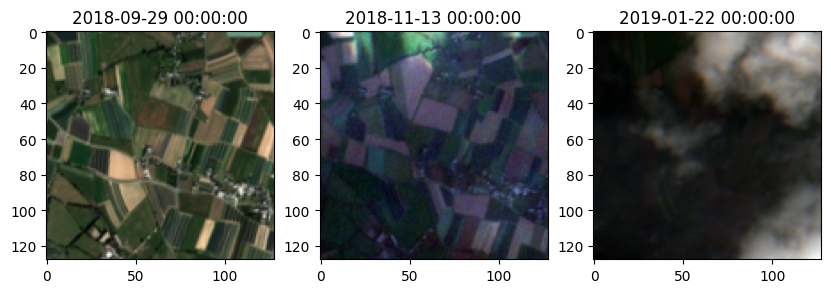

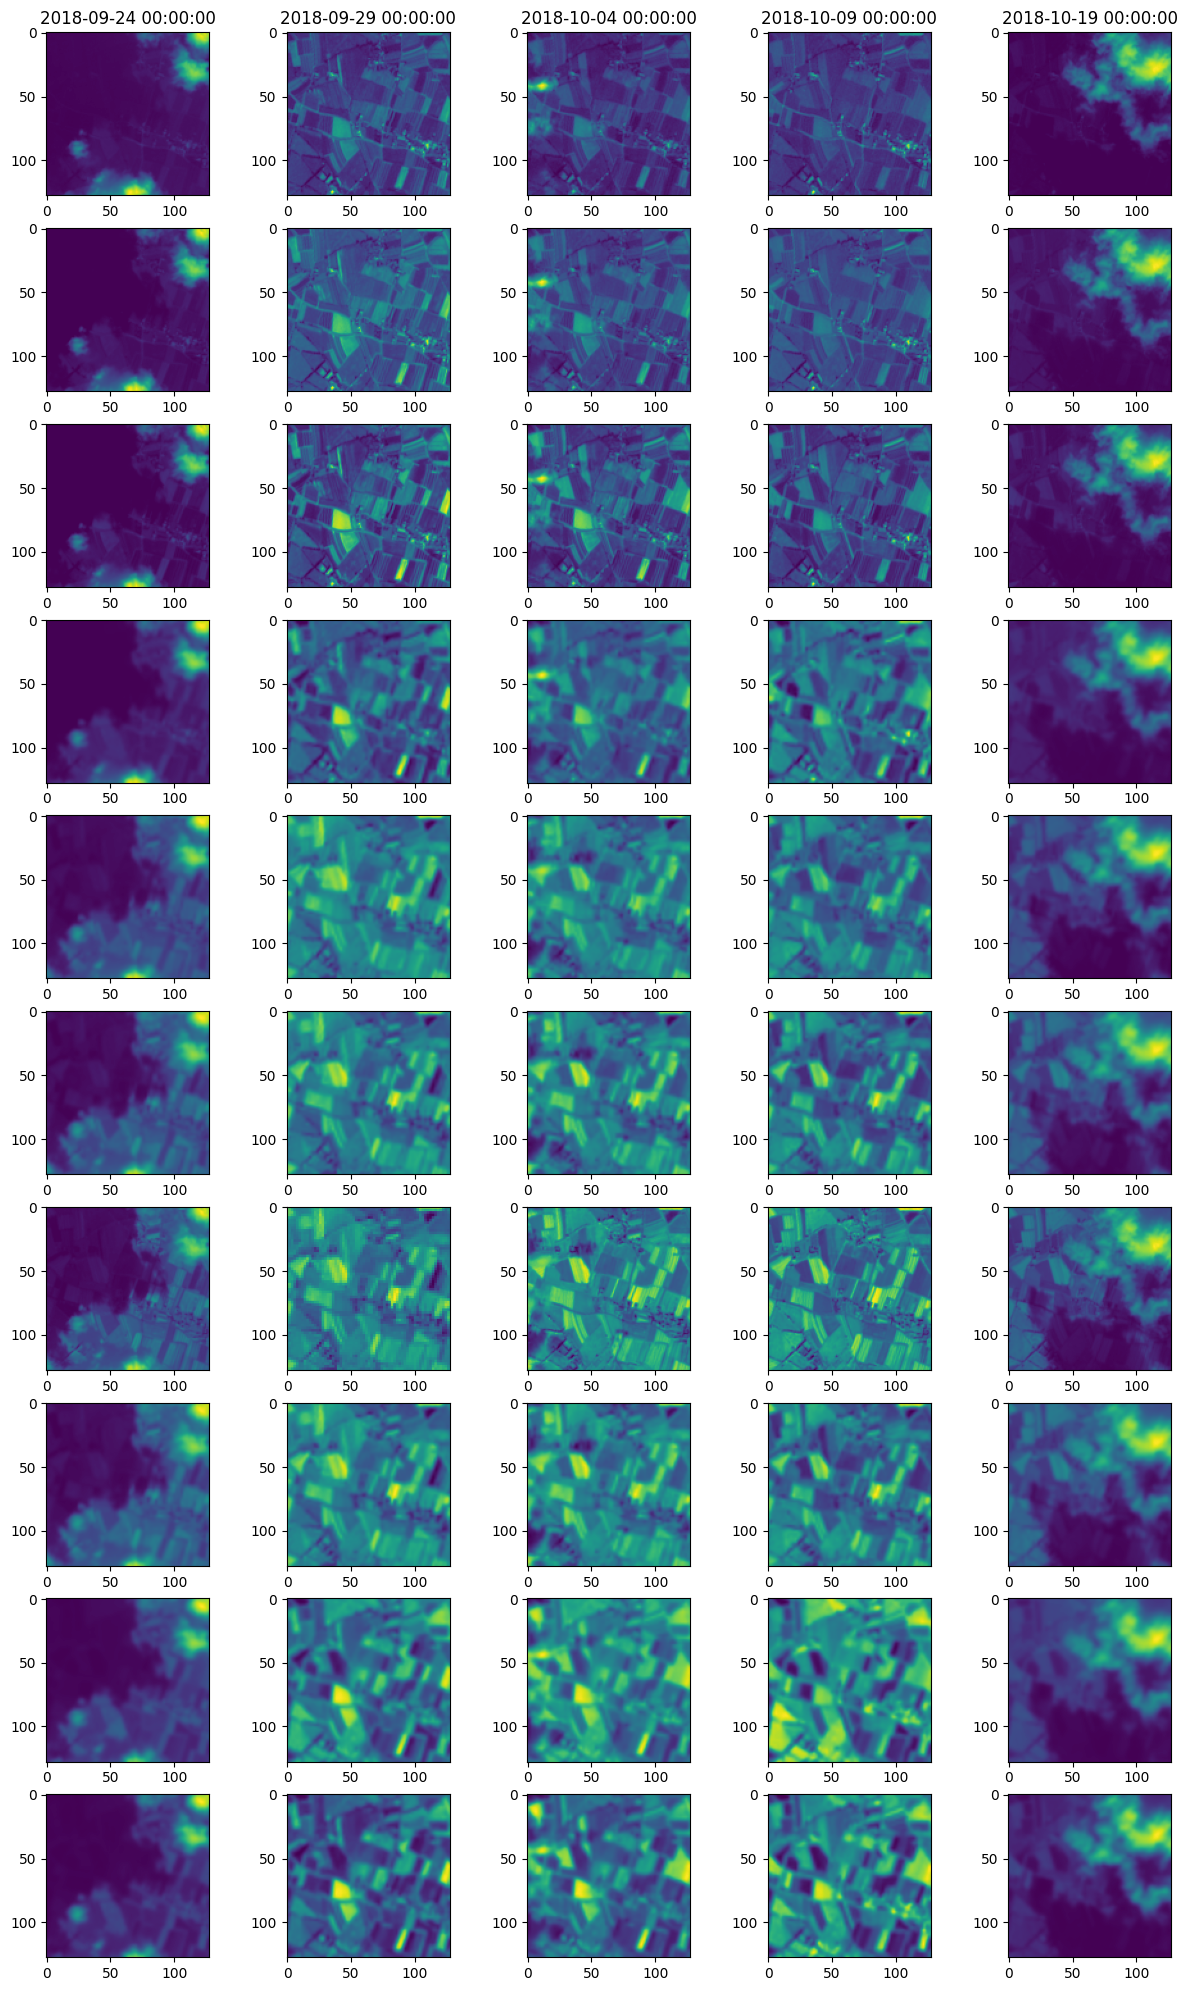

In [17]:
f,axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].imshow(get_rgb(time_series, t_show=1))
axs[0].set_title(f"{metadata[f'{1}_date']}")
axs[1].imshow(get_rgb(time_series, t_show=8))
axs[1].set_title(f"{metadata[f'{8}_date']}")
axs[2].imshow(get_rgb(time_series, t_show=12))
axs[2].set_title(f"{metadata[f'{12}_date']}")

N = 5
f,axs = plt.subplots(10, N, figsize=(15, 25))
for day in range(N):
    for spectral in range(10):
        ax = axs[spectral % 10, day]
        ax.imshow(time_series[day][spectral])

columns = [f"{metadata[f'{i}_date']}" for i in range(N)]
for ax, col in zip(axs[0], columns):
    ax.set_title(col)

In [18]:
parcel_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}ANNOTATIONS/ParcelIDs_*', shuffle=False)
print(f'There are {len(parcel_annotations)} parcel ids annotations.')

parcel_annotation = get_image_and_display_dataset_object_info(parcel_annotations)

target_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}ANNOTATIONS/TARGET_*', shuffle=False)
print(f'There are {len(target_annotations)} target annotations.')

target_annotation = get_image_and_display_dataset_object_info(target_annotations)

semantic_target = target_annotation[0].astype(int)
print(f'Semantic target value range: [{np.amin(semantic_target)}, {np.amax(semantic_target)}]')

There are 2433 parcel ids annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/ANNOTATIONS/ParcelIDs_10000.npy
The shape of the array: (128, 128)
Array value range: [0, 15401718]
There are 2433 target annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET_10000.npy
The shape of the array: (3, 128, 128)
Array value range: [0, 119]
Semantic target value range: [0, 19]


/tmp/ipykernel_31/2228666816.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


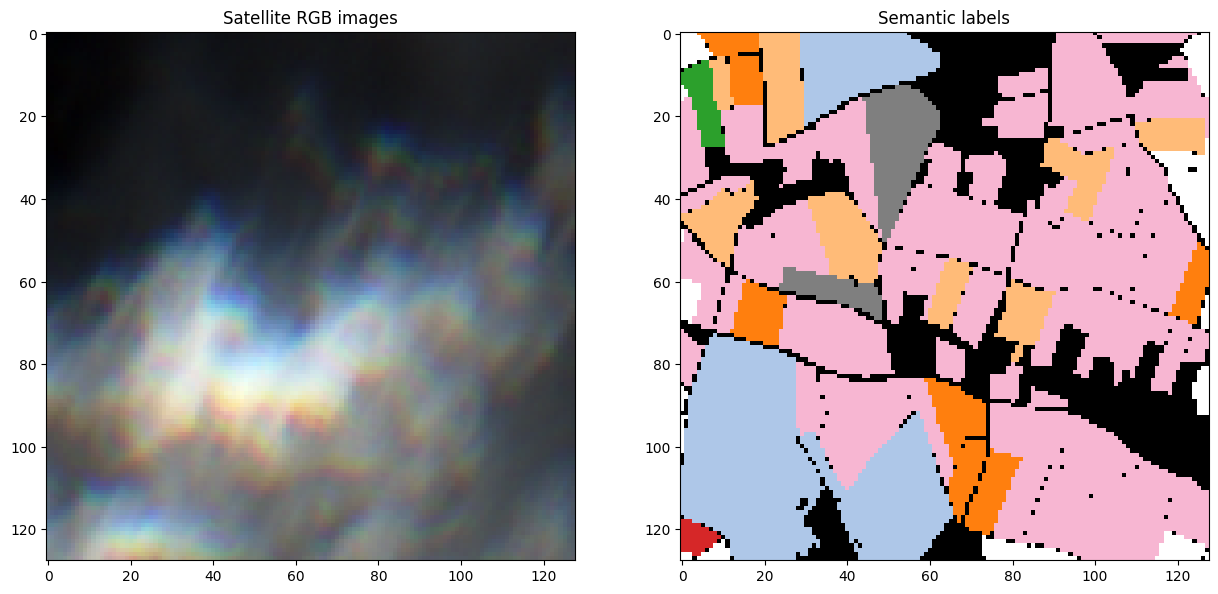

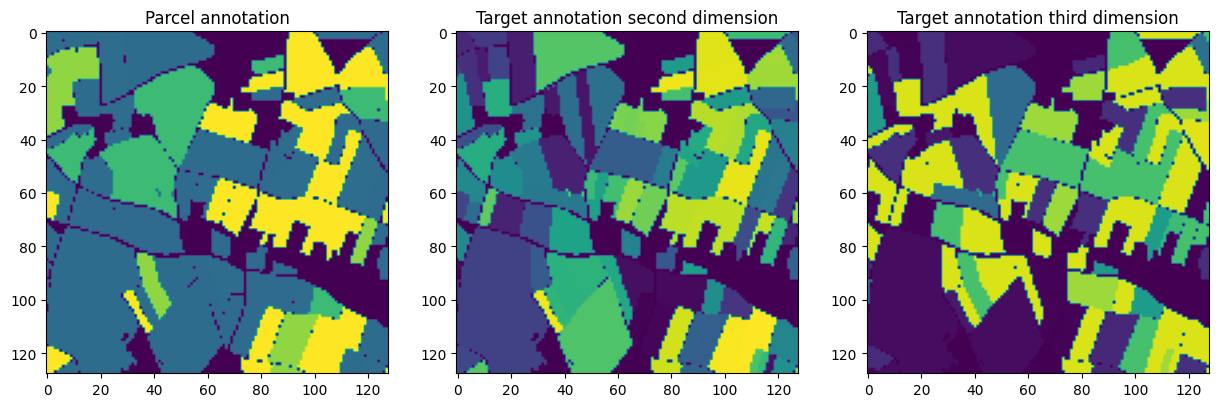

In [25]:
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
semantic_cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

f,axs = plt.subplots(1, 2, figsize=(15, 25))
axs[0].imshow(get_rgb(time_series))
axs[0].set_title('Satellite RGB images')

axs[1].imshow(semantic_target, cmap=semantic_cmap, vmin=0, vmax=19)
axs[1].set_title('Semantic labels')

f,axs = plt.subplots(1, 3, figsize=(15, 25))
axs[0].imshow(parcel_annotation)
axs[0].set_title('Parcel annotation')
axs[1].imshow(target_annotation[1])
axs[1].set_title('Target annotation second dimension')
axs[2].imshow(target_annotation[2])
axs[2].set_title('Target annotation third dimension')

plt.show()

In [26]:
all_instance_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}INSTANCE_ANNOTATIONS/*', shuffle=False)
print(f'There are {len(all_instance_annotations)} instance annotations.')

heatmap_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}INSTANCE_ANNOTATIONS/HEATMAP_*', shuffle=False)
print(f'There are {len(heatmap_annotations)} heatmap instance annotations.')
heatmap_annotation = get_image_and_display_dataset_object_info(heatmap_annotations)

zones_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}INSTANCE_ANNOTATIONS/ZONES_*', shuffle=False)
print(f'There are {len(zones_annotations)} zones instance annotations.')
zone_annotation = get_image_and_display_dataset_object_info(zones_annotations)

instances_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}INSTANCE_ANNOTATIONS/INSTANCES_*', shuffle=False)
print(f'There are {len(instances_annotations)} instances annotations.')
instance_annotation = get_image_and_display_dataset_object_info(instances_annotations)

There are 7299 instance annotations.
There are 2433 heatmap instance annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/INSTANCE_ANNOTATIONS/HEATMAP_10000.npy
The shape of the array: (128, 128)
Array value range: [7.765201269919869e-78, 1.0]
There are 2433 zones instance annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/INSTANCE_ANNOTATIONS/ZONES_10000.npy
The shape of the array: (128, 128)
Array value range: [1, 109]
There are 2433 instances annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_10000.npy
The shape of the array: (128, 128)
Array value range: [0, 109]


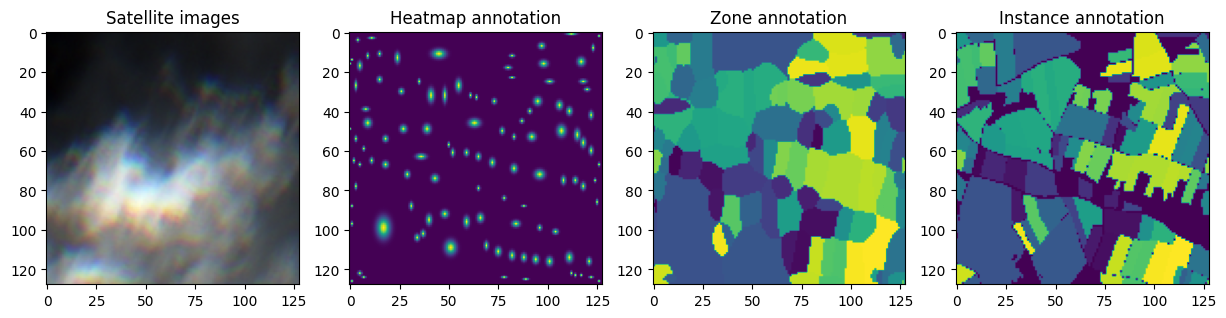

In [27]:
f,axs = plt.subplots(1, 4, figsize=(15, 25))
axs[0].imshow(get_rgb(time_series))
axs[0].set_title('Satellite images')
axs[1].imshow(heatmap_annotation)
axs[1].set_title('Heatmap annotation')
axs[2].imshow(zone_annotation)
axs[2].set_title('Zone annotation')
axs[3].imshow(instance_annotation)
axs[3].set_title('Instance annotation')

plt.show()

In [28]:
NUM_CLASSES = 20
VOID_LABEL = 19
TIME_SERIES_LENGTH = 61
TRAIN_BATCH_SIZE = 5  #It was 8 before
VALIDATION_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1

# Train Model constants
TRAIN_LENGTH = 1455
EPOCHS_NUMBER = 25
STEPS_PER_EPOCH = TRAIN_LENGTH // TRAIN_BATCH_SIZE

In [29]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def pad_time_series(time_series, size):
    """Pad the input time series with repeated values without violating the temporal feature of the series.
       The output time series will be of a given length and will contain some elements repeated k times and the rest k+1.
       Example: pad_time_series([1, 2, 3, 4], 10) => [1 1 1 2 2 2 3 3 4 4].
    """
    input_size = time_series.shape[0]
    diff = size - input_size
    if diff < 0:
        raise ValueError("Time series length exceeds expected result length")
    elif diff == 0:
        return time_series
    
    duplicate_times = math.ceil(size / input_size)
    repeat_times = [duplicate_times] * (size - input_size * (duplicate_times - 1)) + [duplicate_times - 1] * (input_size * duplicate_times - size)
    repeat_times[:(size - sum(repeat_times))] = [v+1 for v in repeat_times[:(size - sum(repeat_times))]]
    
    pad_result = np.repeat(time_series, repeat_times, axis=0)
    return pad_result

def pad_time_series_by_zeros(time_series, size):
    diff = size - time_series.shape[0]
    if diff < 0:
        raise ValueError("Time series length exceeds expected result length")
    elif diff == 0:
        return time_series
    
    pads = np.zeros(shape=(diff,) + time_series.shape[1:])
    pad_result = np.concatenate([pads, time_series], axis=0)
    return pad_result

In [31]:
class ClassWeights(metaclass=Singleton):
    def __init__(self):
        self._class_weights = None
        
    @property
    def class_weights(self):
        if self._class_weights is None:
            self._class_weights = self._calculate_class_weights()
        return self._class_weights
        
    def _calculate_class_weights(self, mode='uniform'):
        """
        Return the list of weights for each class, with the constraint that sum(class_weights) == 1.0
        """
        if mode == 'uniform':
            return [1 / NUM_CLASSES] * NUM_CLASSES
        
        class_weights = [0] * NUM_CLASSES
        for path in patches_metadata['Semantic_segmentation_path']:
            mask = upload_npy_image(path)[0]
            for c in range(NUM_CLASSES):
                class_weights[c] += np.divide(np.count_nonzero(mask == c), mask.shape[0] ** 2)
        class_weights = [w / len(patches_metadata['Semantic_segmentation_path']) for w in class_weights]
        
        class_weights = [1 / w for w in class_weights]
        class_weights = class_weights / sum(class_weights) * 100
        return class_weights

def path_to_timeseries_input(tensor) -> tuple:
    path = tf.get_static_value(tensor).decode("utf-8")
    input_patches = upload_npy_image(path)
    patches = input_patches.swapaxes(1,3).swapaxes(1,2)
    normalized_patches = np.array(list(map(normalize_patch_spectra, patches)))
    pad_patches = pad_time_series_by_zeros(patches, TIME_SERIES_LENGTH)

    segmentation_mask_path = patches_metadata.loc[path]['Semantic_segmentation_path']
    segmentation_mask = upload_npy_image(segmentation_mask_path)[0]
    one_hot_segmentation_mask = one_hot(segmentation_mask, NUM_CLASSES)
    
    class_weights = tf.constant(ClassWeights().class_weights, tf.float32)
    sample_weights = tf.gather(class_weights, indices=tf.cast(segmentation_mask, tf.int32), name='cast_sample_weights')
    
    return pad_patches, one_hot_segmentation_mask, sample_weights

def get_dataset(paths_to_patches):
    files = tf.data.Dataset.list_files(paths_to_patches)
    dataset = files.map(lambda x: tf.py_function(path_to_timeseries_input, [x], [tf.float32, tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_dataset = get_dataset(patches_metadata[patches_metadata['Fold'].isin([1, 2, 3])].index)
validation_dataset = get_dataset(patches_metadata[patches_metadata['Fold'] == 4].index)
test_dataset = get_dataset(patches_metadata[patches_metadata['Fold'] == 5].index)

train_dataset = train_dataset.repeat().batch(TRAIN_BATCH_SIZE)
validation_dataset = validation_dataset.batch(VALIDATION_BATCH_SIZE)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)

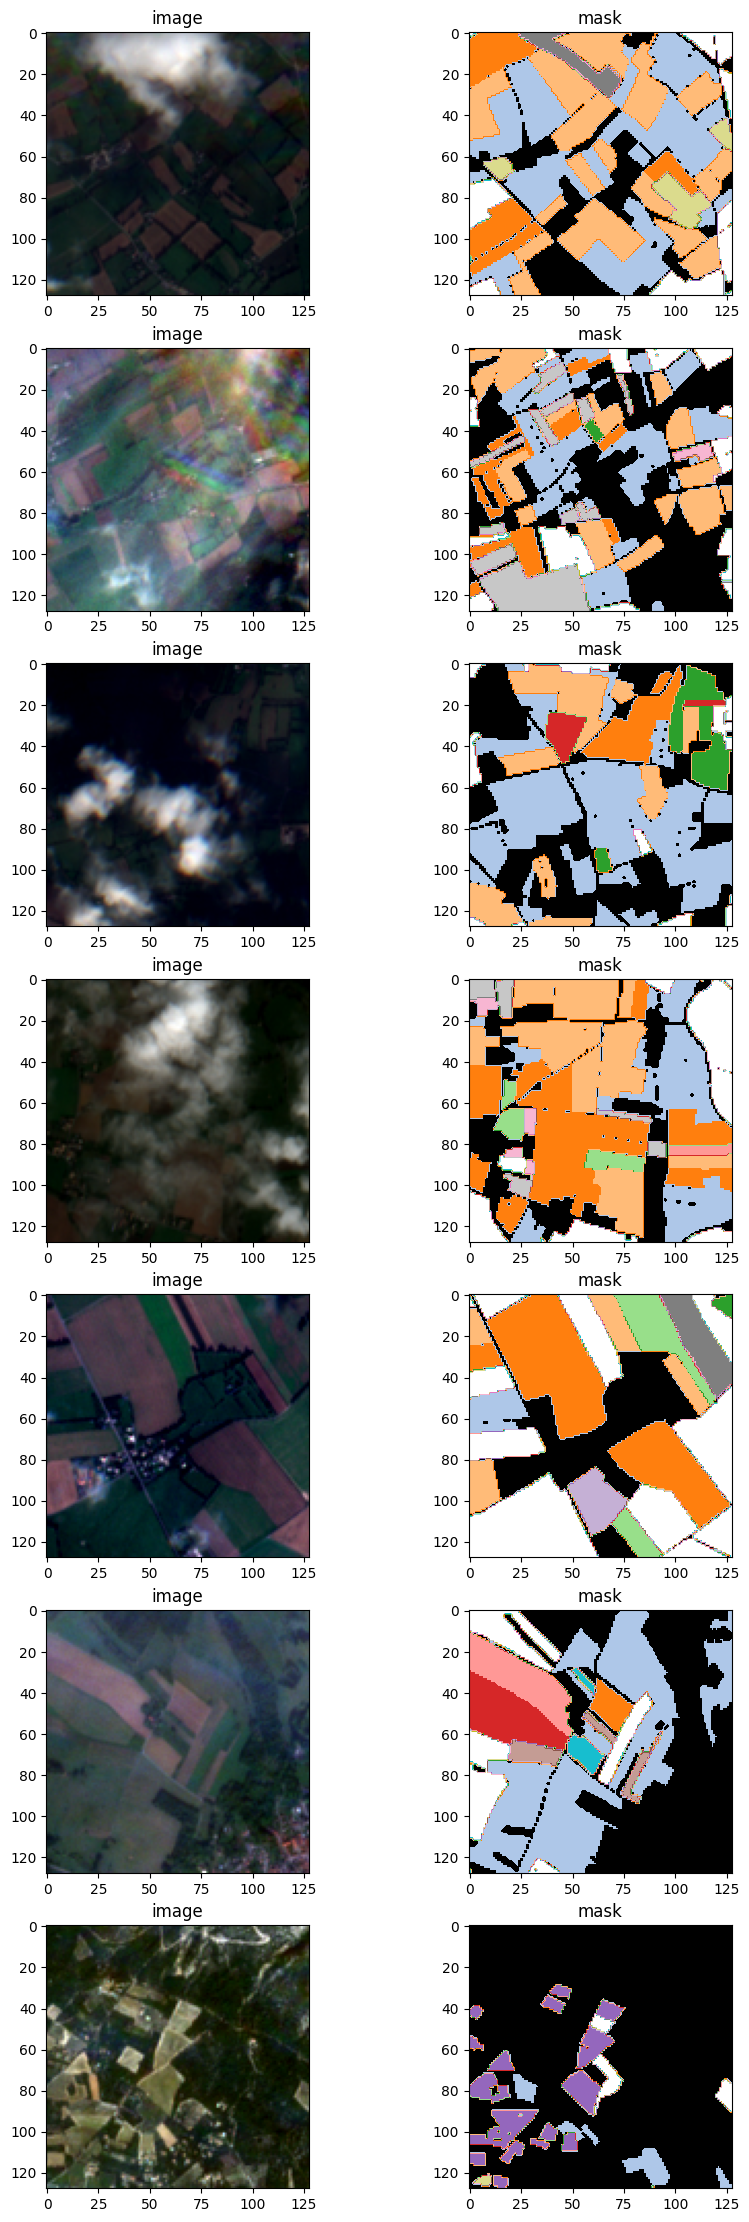

In [32]:
N = 7

f,ax = plt.subplots(N, 2, figsize=(10, 4 * N))
i = 0
for patches, mask_batch, _ in train_dataset.take(N):
    patches = tf.get_static_value(patches)[0].swapaxes(1,2).swapaxes(1,3)
    ax[i, 0].imshow(get_rgb(patches))
    ax[i, 0].set_title('image')
    
    mask = np.argmax(mask_batch[0], axis=2)
    ax[i, 1].imshow(mask, cmap=semantic_cmap, vmin=0, vmax=19)
    ax[i, 1].set_title('mask')
    i += 1

plt.show()